In [1]:
from datetime import datetime
from tensorflow import keras
import math

import tensorflow as tf
from tensorflow import keras
import tensorboard

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!rm -rf ./logs/

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
def plot_images(images, labels, first_n_pairs = 25, plot_weights = False):
    n_col = 5
    first_n_pairs = first_n_pairs if first_n_pairs < len(images) else len(images)
    n_row = math.ceil(first_n_pairs/n_col)
    images, labels = images[:first_n_pairs], labels[:first_n_pairs]
    figsize = (3 * n_col, 4 * n_row) if plot_weights else (2.25 * n_col, 3 * n_row)
    fig, axes = plt.subplots(n_row, n_col, figsize = figsize)
    for idx, (image, label) in enumerate(zip(images, labels)):
        ax = axes[idx // n_col, idx % n_col]
        ax.imshow(image, cmap = 'gray')
        ax.set_title(f"{'Weights' if plot_weights else 'Label'}: {label}")
    plt.tight_layout()
    plt.show()

In [5]:
def add_noise(image, noise_typ='gauss'):
    if noise_typ == "gauss":
        row,col= image.shape
        mean = 0
        var = 255
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
    
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.05
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        out[tuple(coords)] = 1
        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[tuple(coords)] = 0
        return out
    
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    
    elif noise_typ =="speckle":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        noisy = image + image * gauss
        return noisy

Training images:


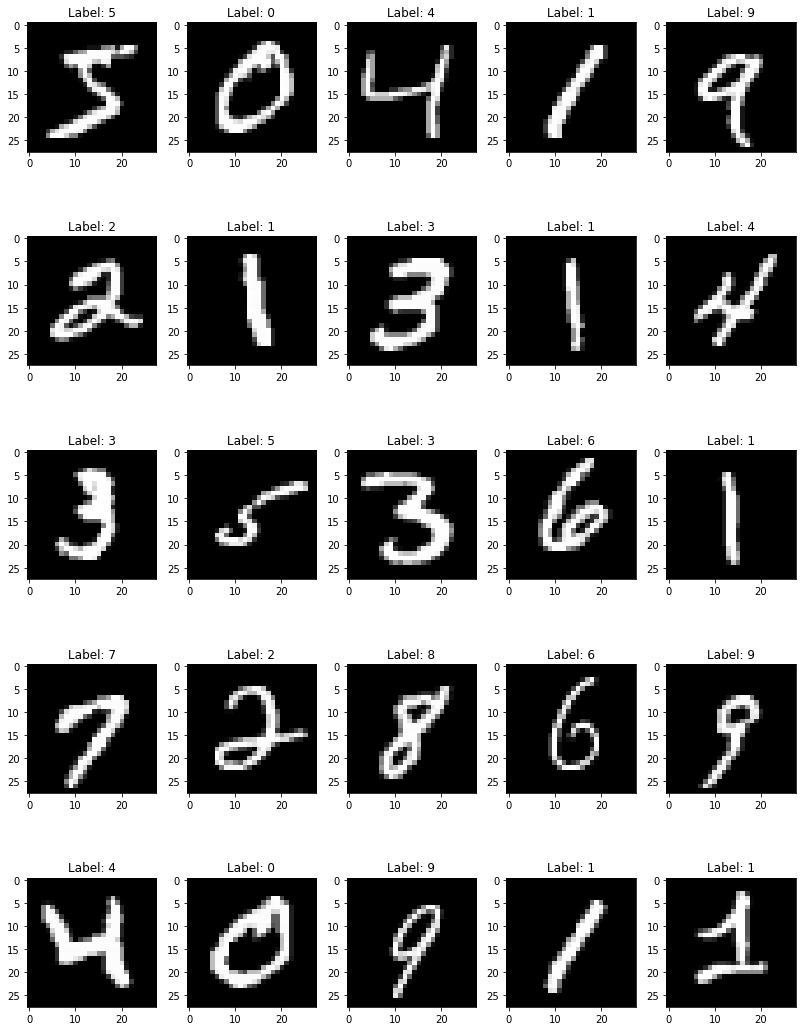

In [6]:
print("Training images:")
plot_images(x_train, y_train)

In [7]:
x_test_w_gauss = np.array([add_noise(x, noise_typ = "gauss") for x in x_test])
x_test_w_sp = np.array([add_noise(x, noise_typ = "s&p") for x in x_test])

Testing images With Gaussian Noise:


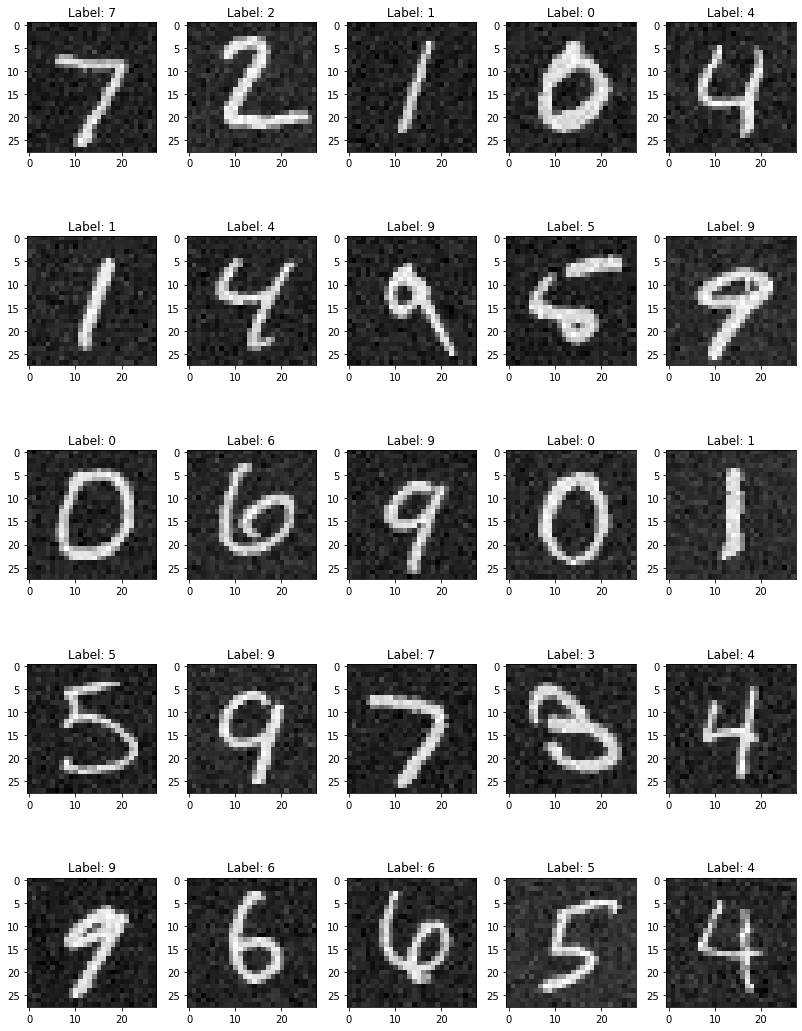

In [8]:
print("Testing images With Gaussian Noise:")
plot_images(x_test_w_gauss, y_test)

Testing images With Salt & Pepper Noise:


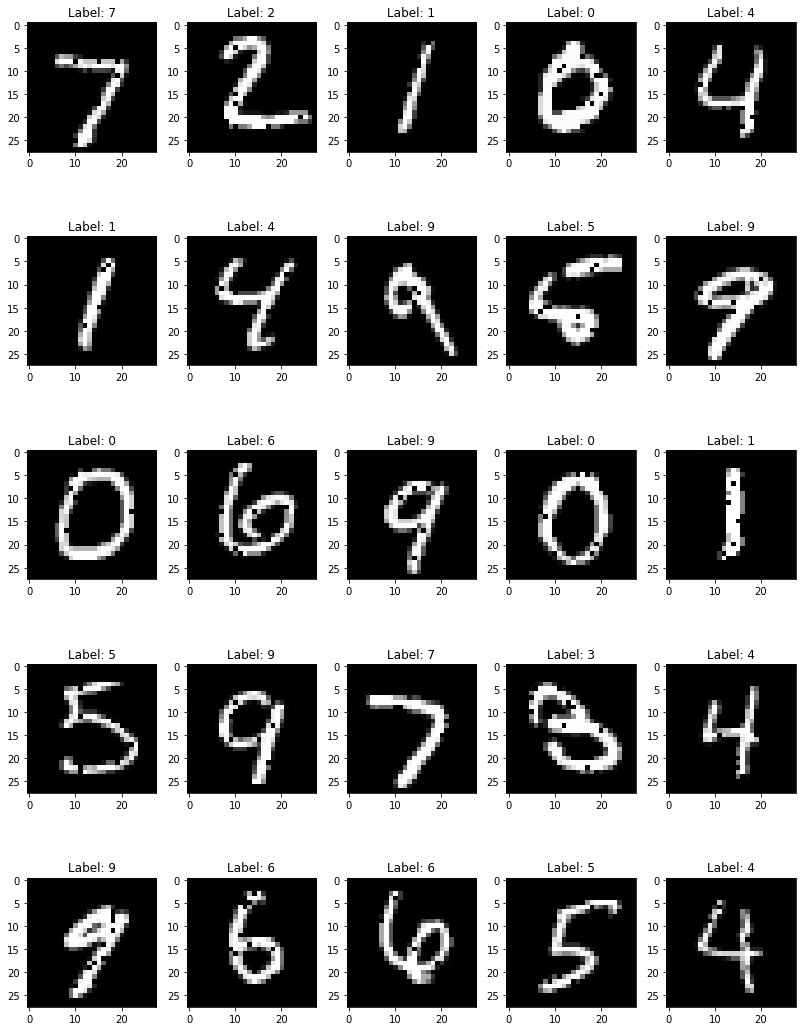

In [9]:
print("Testing images With Salt & Pepper Noise:")
plot_images(x_test_w_sp, y_test)

In [10]:
x_train, x_test_w_gauss, x_test_w_sp = x_train / 255.0, x_test_w_gauss / 255.0, x_test_w_sp / 255.0
input_x_axis, input_y_axis = x_train.shape[1], x_train.shape[2]

In [11]:
model = keras.models.Sequential(
[
    keras.layers.Flatten(input_shape=(input_x_axis, input_y_axis), name='input_layer'),
    keras.layers.Dense(256, activation='relu', name='hidden_layer'),
    keras.layers.Dense(10, activation='softmax', name='output_layer'),
],
name = 'MLP'
)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Flatten)        (None, 784)               0         
_________________________________________________________________
hidden_layer (Dense)         (None, 256)               200960    
_________________________________________________________________
output_layer (Dense)         (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


In [12]:
logdir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

model.fit(
    x_train, 
    y_train, 
    batch_size = 64,
    epochs=10,
    validation_split=0.2,
    use_multiprocessing=True,
    callbacks=[tensorboard_callback]
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 4s 79us/sample - loss: 0.2845 - accuracy: 0.9204 - val_loss: 0.1489 - val_accuracy: 0.9579
Epoch 2/10
48000/48000 [==============================] - 3s 62us/sample - loss: 0.1217 - accuracy: 0.9642 - val_loss: 0.1111 - val_accuracy: 0.9669
Epoch 3/10
48000/48000 [==============================] - 3s 62us/sample - loss: 0.0803 - accuracy: 0.9762 - val_loss: 0.1027 - val_accuracy: 0.9690
Epoch 4/10
48000/48000 [==============================] - 3s 63us/sample - loss: 0.0584 - accuracy: 0.9827 - val_loss: 0.0920 - val_accuracy: 0.9728
Epoch 5/10
48000/48000 [==============================] - 3s 63us/sample - loss: 0.0436 - accuracy: 0.9872 - val_loss: 0.0830 - val_accuracy: 0.9759
Epoch 6/10
48000/48000 [==============================] - 3s 70us/sample - loss: 0.0338 - accuracy: 0.9904 - val_loss: 0.0891 - val_accuracy: 0.9743
Epoch 7/10
48000/48000 [==============================] 

In [13]:
model.predict(x_test_w_gauss[:1])

array([[2.40929388e-09, 1.40402247e-11, 2.69020802e-07, 1.02995495e-04,
        9.73924518e-16, 2.73680811e-09, 9.10706995e-17, 9.99896049e-01,
        6.85229722e-08, 5.56635143e-07]], dtype=float32)

In [14]:
model.evaluate(x_test_w_gauss,  y_test, verbose=2)

10000/1 - 1s - loss: 0.0407 - accuracy: 0.9775


[0.07804863393506384, 0.9775]

In [15]:
model.evaluate(x_test_w_sp,  y_test, verbose=2)

10000/1 - 0s - loss: 0.0393 - accuracy: 0.9782


[0.07643032355501782, 0.9782]

In [16]:
output_layer_weights = model.layers[-1].get_weights()[0]
output_layer_weights = output_layer_weights.T.reshape(10, 16, 16)
output_layer_weights_labels = [i for i in range(len(output_layer_weights))]

Output Layer Weights images:


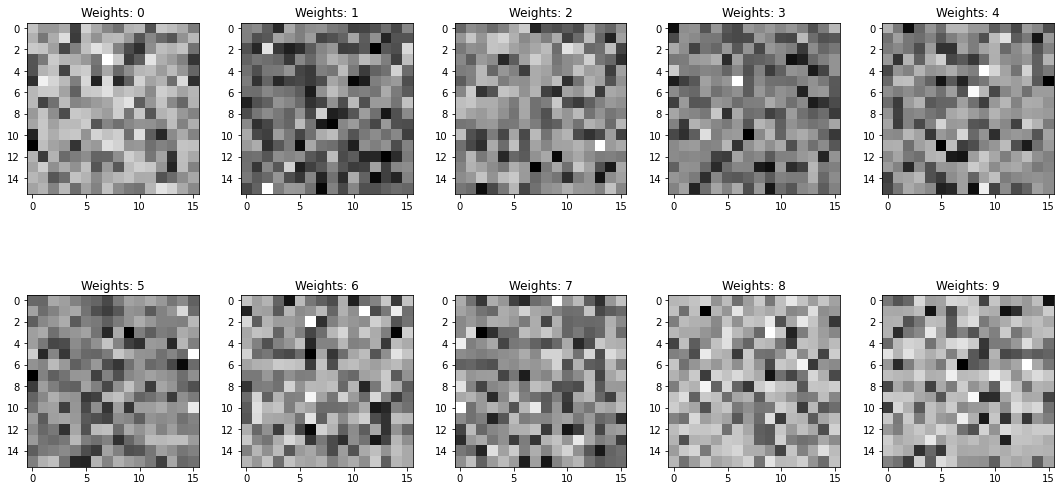

In [17]:
print("Output Layer Weights images:")
plot_images(output_layer_weights, output_layer_weights_labels, plot_weights=True)